In [1]:
from __future__ import annotations

import pathlib

import polars
import seaborn
from matplotlib import pyplot as plt

_ = polars.Config.set_tbl_rows(200)

In [2]:
def load_data(directory: pathlib.Path) -> polars.DataFrame:
    dfs = []
    for run in directory.glob('**/results.csv'):
        try:
            df = polars.read_csv(run)
            # Drop first row which was the cold-start run
            df = df.tail(len(df) - 1)
            if len(df) > 0:
                dfs.append(df)
        except Exception as e:
            print(f'Error loading {run}... skipping: {e}')
    return polars.concat(dfs)

In [3]:
results = load_data(pathlib.Path('../runs-prod/launch-latency-v2/'))
results

framework,num_nodes,num_workers_per_node,num_actors,startup_time,shutdown_time
str,i64,i64,i64,f64,f64
"""aeris""",1,2,2,0.007996,0.003317
"""aeris""",1,2,2,0.007067,0.003041
"""aeris""",1,2,2,0.006955,0.003181
"""aeris""",1,2,2,0.006923,0.00343
"""aeris""",1,2,2,0.006993,0.003727
"""dask""",32,52,1664,10.203962,0.327894
"""dask""",32,52,1664,10.131405,0.326477
"""dask""",32,52,1664,10.156478,0.325113
"""dask""",32,52,1664,10.203867,0.32411


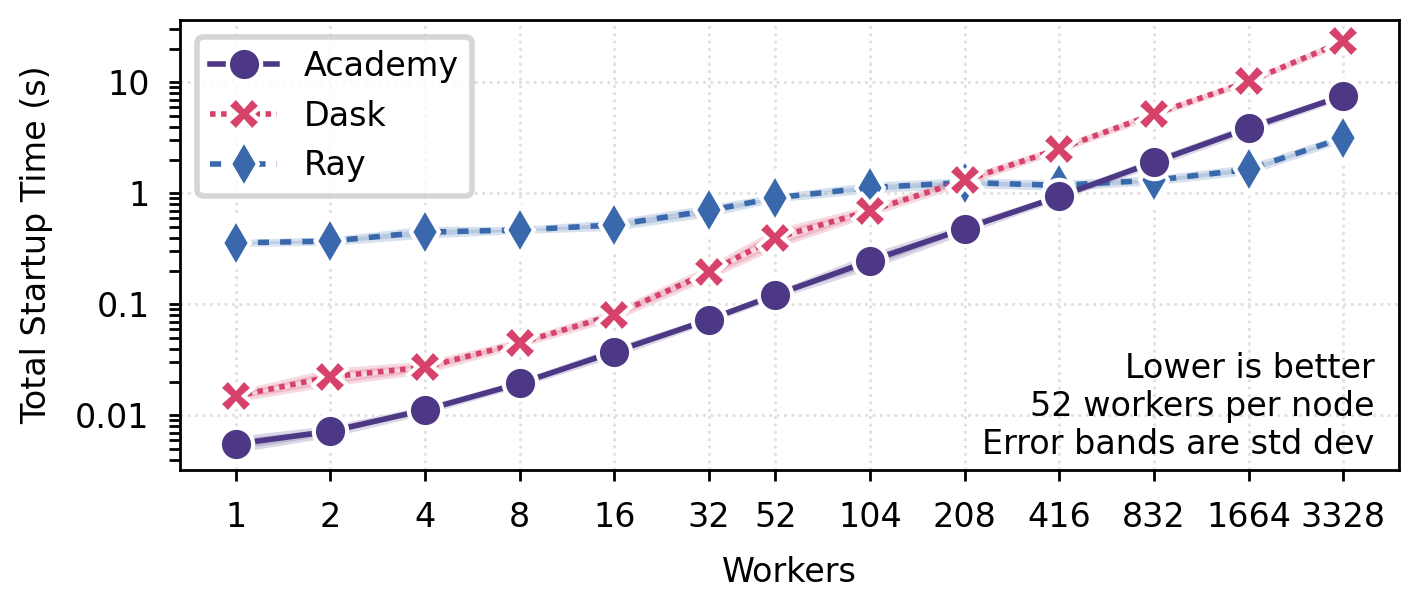

In [7]:
fig, axs = plt.subplots(1, 1)

xticks = sorted(set(results['num_actors'].to_list()))
yticks = [0.01, 0.1, 1, 10]

dashes = {'ray': (2, 2), 'dask': (1, 1), 'aeris': ()}
markers = {'ray': 'd', 'dask': 'X', 'aeris': 'o'}
palette = {'ray': '#3969AC', 'dask': '#D64269', 'aeris': '#4D3886'}

handle = seaborn.lineplot(
    results,
    x='num_actors',
    y='startup_time',
    hue='framework',
    hue_order=['ray', 'dask', 'aeris'],
    errorbar='sd',
    # err_style='bars',
    style='framework',
    dashes=dashes,
    markers=markers,
    palette=palette,
    ax=axs,
)
handles, _ = axs.get_legend_handles_labels()
axs.legend(
    handles=handles[::-1],
    title=None,
    labels=['Academy', 'Dask', 'Ray'],
)
_ = handle.set(
    xscale='log',
    yscale='log',
    xlabel='Workers',
    ylabel='Total Startup Time (s)',
)
handle.set_xticks(xticks, minor=False)
handle.set_xticklabels([str(x) for x in xticks])
axs.tick_params(axis='x', which='minor', bottom=False)
handle.set_yticks(yticks, minor=False)
handle.set_yticklabels([str(y) for y in yticks])

axs.annotate(
    'Lower is better\n52 workers per node\nError bands are std dev',
    xy=(0.98, 0.02),
    xycoords=('axes fraction'),
    ha='right',
    va='bottom',
)

fig.tight_layout()
plt.draw()
fig.set_size_inches(3.35, 1.25)
fig.savefig('figures/actor-launch-latency.pdf')